# Project 1 - part A

Dataset with the 30 Stocks from S&P500 Index from 2014 to 2024

In [1]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("../project1-partA/project1_data.csv")
df_SP500 = pd.read_csv("../project1-partA/sp500_px_open_last.csv")
df = df.dropna() # VRTX has null PX_LAST in 2015-05-12	
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75479 entries, 0 to 75479
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          75479 non-null  object 
 1   PX_LAST       75479 non-null  float64
 2   CUR_MKT_CAP   75479 non-null  float64
 3   PX_VOLUME     75479 non-null  float64
 4   Ticker        75479 non-null  object 
 5   Market_Value  75479 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.0+ MB


## Daily Return

In [2]:
tickers = df["Ticker"].unique()
all_tickers_df = []

for tik in tickers:
    mask = df["Ticker"]==tik
    last_day_value = df.loc[mask,'PX_LAST'].shift(1)
    today_value = df.loc[mask,'PX_LAST']
    df.loc[mask, 'Daily_Return'] = (last_day_value - today_value) / last_day_value

df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0
df

,Date,PX_LAST,CUR_MKT_CAP,PX_VOLUME,Ticker,Market_Value,Daily_Return
0,2014-01-02,76.27,134027.7199,5212460.0,DIS,1.022229e+07,0.000000
1,2014-01-03,76.11,133746.5552,4061042.0,DIS,1.017945e+07,0.002098
2,2014-01-06,75.82,133236.9441,6816693.0,DIS,1.010203e+07,0.003810
3,2014-01-07,76.34,134150.7295,4511157.0,DIS,1.024107e+07,-0.006858
4,2014-01-08,75.22,132182.5763,10914858.0,DIS,9.942773e+06,0.014671
...,...,...,...,...,...,...,...
75475,2023-12-22,80.43,15764.7189,835062.0,TXT,1.267956e+06,-0.004496
75476,2023-12-26,80.73,15823.5205,678910.0,TXT,1.277433e+06,-0.003730
75477,2023-12-27,80.71,15819.6004,899628.0,TXT,1.276800e+06,0.000248
75478,2023-12-28,80.75,15827.4407,603963.0,TXT,1.278066e+06,-0.000496


## Value-Weighted and Equally-Weighted Portfolio

In [3]:
n_tickers = len(df["Ticker"].unique())

df['Date'] = pd.to_datetime(df['Date'])

# Create a dictionary to store DataFrames
dfs_by_month_year = {}

# Group by year and month
grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

# Iterate through the groups and create separate DataFrames
for (year, month), group in grouped:
    dfs_by_month_year[(year, month)] = group.reset_index(drop=True)

# Setting the first portfolio weight
equal_weight = 1 / n_tickers
dfs_by_month_year[(2014, 1)]["Equal_Weight"] = equal_weight

# This is the value that we start with (100%)
cumulative_value = 1

for y in range(2014,2024):
    for m in range(1,13):
        # Get the dataset from this specific year and month
        a = dfs_by_month_year[(y, m)]
        
        # Calculate the portfolio daily return
        a["Equal_weight*Daily_Return"] = a["Equal_Weight"]*a["Daily_Return"]
        EWP_daily_returns = a.groupby("Date")["Equal_weight*Daily_Return"].sum().rename("EWP_daily_return")
        
        # Update the cumulative return after this month
        for EWP_daily_return in EWP_daily_returns:
            cumulative_value*=(1+EWP_daily_return)
            
        # Use the cumulative value at the end of the month and divide it by the number of tickers
        next_month_Equal_weight = cumulative_value / n_tickers
        
        # This code is just for the loop don't get an error
        if y<2023:
            if m==12:
                b = dfs_by_month_year[(y+1, 1)]
            else:
                b = dfs_by_month_year[(y, m+1)]
        else:
            if m<12:
                b = dfs_by_month_year[(y, m+1)]
            else:
                break
            
        b["Equal_Weight"] = next_month_Equal_weight

In [4]:
dfs_by_month_year[(2023, 12)]

,Date,PX_LAST,CUR_MKT_CAP,PX_VOLUME,Ticker,Market_Value,Daily_Return,Equal_Weight,Equal_weight*Daily_Return
0,2023-12-01,92.58,169450.6480,11898169.0,DIS,1.568774e+07,0.001187,0.011832,0.000014
1,2023-12-04,92.01,168407.3679,12602805.0,DIS,1.549516e+07,0.006157,0.011832,0.000073
2,2023-12-05,90.79,166174.3825,12356988.0,DIS,1.508697e+07,0.013259,0.011832,0.000157
3,2023-12-06,91.50,167473.9068,10462040.0,DIS,1.532386e+07,-0.007820,0.011832,-0.000093
4,2023-12-07,92.35,169029.6753,10264684.0,DIS,1.560989e+07,-0.009290,0.011832,-0.000110
...,...,...,...,...,...,...,...,...,...
595,2023-12-22,80.43,15764.7189,835062.0,TXT,1.267956e+06,-0.004496,0.011832,-0.000053
596,2023-12-26,80.73,15823.5205,678910.0,TXT,1.277433e+06,-0.003730,0.011832,-0.000044
597,2023-12-27,80.71,15819.6004,899628.0,TXT,1.276800e+06,0.000248,0.011832,0.000003
598,2023-12-28,80.75,15827.4407,603963.0,TXT,1.278066e+06,-0.000496,0.011832,-0.000006


In [5]:
number_of_tickers_each_day = df.groupby("Date")["Ticker"].unique()
b = number_of_tickers_each_day.iloc[1]

In [6]:
result = [item for item in a if item not in b]

print(result)  # Output: ['apple']

['Date', 'PX_LAST', 'CUR_MKT_CAP', 'PX_VOLUME', 'Ticker', 'Market_Value', 'Daily_Return', 'Equal_Weight', 'Equal_weight*Daily_Return']


## Pie chart for showing the percentage of each Stock in the Value-Weighted portfolio

In [7]:
import time
from datetime import datetime
specific_date = "2014-03-06"

def pie_chart_for_specific_date(df,date):
    df_for_pie = df[df["Date"]==date]
    fig = px.pie(df_for_pie, values='Value_Weight', names='Ticker', title=f'Value-Weighted of portfolio in {date}',width=600)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()
    
pie_chart_for_specific_date(df,specific_date)

In [ ]:
df

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,Market_Value,Total_Market_Value_Day,Value_Weight,Equal_Weight,Daily_Return
0,2014-01-02,76.27,76.04,76.500,75.900,5212460.0,134027.7199,DIS,1.022229e+07,4.859792e+07,0.210344,0.033333,0.003025
1,2014-01-03,76.11,76.30,76.697,76.010,4061042.0,133746.5552,DIS,1.017945e+07,4.840901e+07,0.210280,0.033333,-0.002490
2,2014-01-06,75.82,76.53,76.840,75.490,6816693.0,133236.9441,DIS,1.010203e+07,4.849603e+07,0.208306,0.033333,-0.009277
3,2014-01-07,76.34,76.12,76.700,75.900,4511157.0,134150.7295,DIS,1.024107e+07,4.965378e+07,0.206249,0.033333,0.002890
4,2014-01-08,75.22,76.13,76.280,74.810,10914858.0,132182.5763,DIS,9.942773e+06,4.934948e+07,0.201477,0.033333,-0.011953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75167,2024-08-06,54.08,52.93,55.110,52.659,16405667.0,74061.2621,CMG,4.005233e+06,5.450343e+08,0.007349,0.033333,0.021727
75168,2024-08-07,53.63,54.50,55.300,53.410,11238844.0,73444.9979,CMG,3.938855e+06,5.320586e+08,0.007403,0.033333,-0.015963
75169,2024-08-08,54.32,54.00,54.890,53.740,9305774.0,74389.9363,CMG,4.040861e+06,5.535762e+08,0.007300,0.033333,0.005926
75170,2024-08-09,55.55,54.90,56.140,54.530,11569747.0,76074.3918,CMG,4.225932e+06,5.601571e+08,0.007544,0.033333,0.011840


In [ ]:
# Rebalance these portfolios in the first day of the month based on the information on the last day (1-day lag)
# For example the day 2014-01-31 and 2014-02-03 now have the same Value_Weight
tickers = df["Ticker"].unique()
list_of_df_tik = []
for tik in tickers:
    df_tik = df.loc[df["Ticker"]==tik,:]
    df_tik.set_index("Date",inplace=True)
    last_day_prev_month = df_tik['Value_Weight'].resample('M').last()
    first_day_curr_month = df_tik.groupby([df_tik.index.year, df_tik.index.month]).head(1)
    last_day_prev_month_list = last_day_prev_month.to_list()
    last_day_prev_month_list.insert(0,first_day_curr_month["Value_Weight"][0])
    last_day_prev_month_list.pop(-1)
    first_day_curr_month.loc[:,"Value_Weight"] = last_day_prev_month_list
    mask = df_tik.index.isin(first_day_curr_month.index)
    df_tik.loc[mask, 'Value_Weight'] = first_day_curr_month
    df_tik.reset_index(inplace=True)
    list_of_df_tik.append(df_tik)

In [ ]:
new_df = pd.concat(list_of_df_tik)
new_df

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,Market_Value,Total_Market_Value_Day,Value_Weight,Equal_Weight,Daily_Return
0,2014-01-02,76.27,76.04,76.500,75.900,5212460.0,134027.7199,DIS,1.022229e+07,4.859792e+07,0.210344,0.033333,0.003025
1,2014-01-03,76.11,76.30,76.697,76.010,4061042.0,133746.5552,DIS,1.017945e+07,4.840901e+07,0.210280,0.033333,-0.002490
2,2014-01-06,75.82,76.53,76.840,75.490,6816693.0,133236.9441,DIS,1.010203e+07,4.849603e+07,0.208306,0.033333,-0.009277
3,2014-01-07,76.34,76.12,76.700,75.900,4511157.0,134150.7295,DIS,1.024107e+07,4.965378e+07,0.206249,0.033333,0.002890
4,2014-01-08,75.22,76.13,76.280,74.810,10914858.0,132182.5763,DIS,9.942773e+06,4.934948e+07,0.201477,0.033333,-0.011953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2024-08-06,54.08,52.93,55.110,52.659,16405667.0,74061.2621,CMG,4.005233e+06,5.450343e+08,0.007349,0.033333,0.021727
2666,2024-08-07,53.63,54.50,55.300,53.410,11238844.0,73444.9979,CMG,3.938855e+06,5.320586e+08,0.007403,0.033333,-0.015963
2667,2024-08-08,54.32,54.00,54.890,53.740,9305774.0,74389.9363,CMG,4.040861e+06,5.535762e+08,0.007300,0.033333,0.005926
2668,2024-08-09,55.55,54.90,56.140,54.530,11569747.0,76074.3918,CMG,4.225932e+06,5.601571e+08,0.007544,0.033333,0.011840


In [ ]:
new_df["Value_Weight*Daily_Return"] = new_df["Value_Weight"]*new_df["Daily_Return"]
new_df["Equal_Weight*Daily_Return"] = new_df["Equal_Weight"]*new_df["Daily_Return"]

In [ ]:
value_weighted_return = new_df.groupby("Date")["Value_Weight*Daily_Return"].sum()

equal_weighted_return = new_df.groupby("Date")["Equal_Weight*Daily_Return"].sum()

portfolios = pd.DataFrame({
    "Daily_Return_with_Value_Weighted_Portfolio": value_weighted_return,
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weighted_return
})

portfolios.reset_index(inplace=True)
portfolios

,Date,Daily_Return_with_Value_Weighted_Portfolio,Daily_Return_with_Equal_Weighted_Portfolio
0,2014-01-02,-0.003324,-0.004958
1,2014-01-03,-0.003096,0.002189
2,2014-01-06,-0.003736,-0.003695
3,2014-01-07,0.006103,0.003307
4,2014-01-08,-0.002151,0.003586
...,...,...,...
2665,2024-08-06,-0.002248,0.005482
2666,2024-08-07,-0.020181,-0.019729
2667,2024-08-08,0.011787,0.015819
2668,2024-08-09,0.014371,0.002092


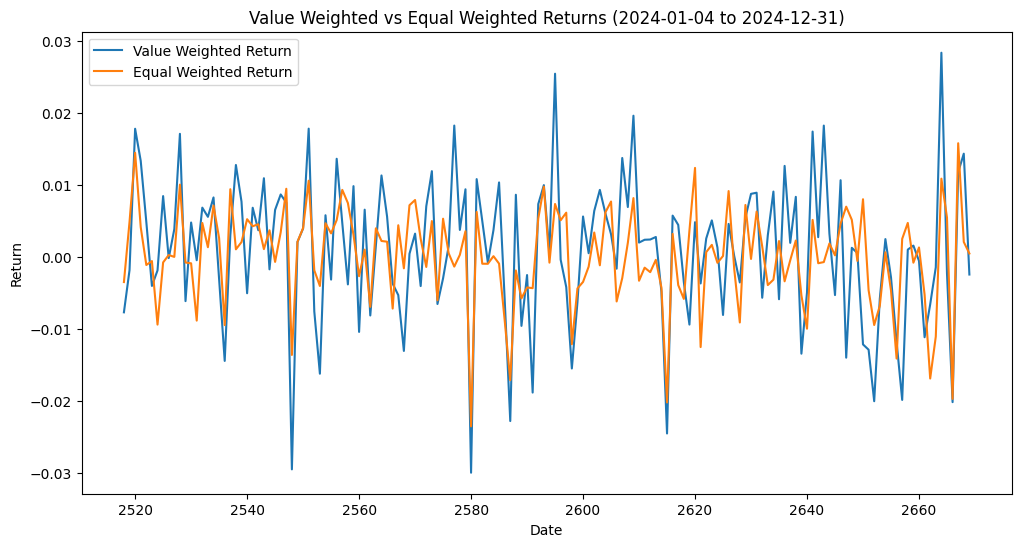

In [ ]:
import matplotlib.pyplot as plt

# Define the date range (adjust the dates to your specific needs)
start_date = "2024-01-04"
end_date = "2024-12-31"

filtered_df = portfolios[(portfolios["Date"] >= start_date) & (portfolios["Date"] <= end_date)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df.index, filtered_df["Daily_Return_with_Value_Weighted_Portfolio"], label="Value Weighted Return")
plt.plot(filtered_df.index, filtered_df["Daily_Return_with_Equal_Weighted_Portfolio"], label="Equal Weighted Return")

plt.title(f"Value Weighted vs Equal Weighted Returns ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

plt.show()

## Annualized Average Return

In [ ]:
# Compute annualized average return
annualized_df =portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio"]].mean()
annualized_df.reset_index(inplace=True)
annualized_df.rename(columns={"Daily_Return_with_Value_Weighted_Portfolio":"Average_Annual_Return_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio":"Average_Annual_Return_with_Equal_Weighted_Portfolio"},inplace=True)


# Compute annualized average return S&P500
annualized_dfSP500 = df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].mean()

In [ ]:
annualized_df

,Date,Average_Annual_Return_with_Value_Weighted_Portfolio,Average_Annual_Return_with_Equal_Weighted_Portfolio
0,2014,-0.000207,0.000129
1,2015,0.000017,0.000083
2,2016,0.000300,0.000711
3,2017,0.000354,0.000207
4,2018,-0.000490,-0.000513
5,2019,0.000494,0.000562
6,2020,0.000680,-0.000226
7,2021,0.000424,0.000361
8,2022,-0.000377,0.000271
9,2023,0.001657,0.000665


## Annualized Standard Deviation

In [ ]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio"]].std()
standard_deviation_return = standard_deviation_return.rename(columns={"Daily_Return_with_Value_Weighted_Portfolio":"Standard_Deviation_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio":"Standard_Deviation_with_Equal_Weighted_Portfolio"})
standard_deviation_return

,Standard_Deviation_with_Value_Weighted_Portfolio,Standard_Deviation_with_Equal_Weighted_Portfolio
Date,,
2014,0.007647,0.006874
2015,0.008419,0.007704
2016,0.007129,0.007798
2017,0.004038,0.003922
2018,0.011319,0.009192
2019,0.006691,0.006043
2020,0.014052,0.014706
2021,0.008453,0.007624
2022,0.015787,0.012735


In [ ]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_annual_rate = 0.04
risk_free_daily_rate = risk_free_annual_rate / 365

## Sharpe Ratio and Information Ratio with annualized Average Return

In [ ]:
# VWP = Value-Weighted Portfolio
# EWP = Equal-Weighted Portfolio
annualized_df["Excess_Return_VWP"] = annualized_df["Average_Annual_Return_with_Value_Weighted_Portfolio"] - risk_free_annual_rate
annualized_df["Excess_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"] - risk_free_annual_rate
risk_premium_VWP = annualized_df["Excess_Return_VWP"].mean()
risk_premium_EWP = annualized_df["Excess_Return_EWP"].mean()

# Get the Squared deviations from mean (Risk premium in each port)
annualized_df["Squared_Deviations_From_Mean_VWP"] = (annualized_df["Excess_Return_VWP"] - risk_premium_VWP)**2
annualized_df["Squared_Deviations_From_Mean_EWP"] = (annualized_df["Excess_Return_EWP"] - risk_premium_EWP)**2

# Get the standard deviation from mean (Risk premium in each port)
SD_Excess_Return_VWP = annualized_df["Squared_Deviations_From_Mean_VWP"].std()
SD_Excess_Return_EWP = annualized_df["Squared_Deviations_From_Mean_EWP"].std()
print("Risk Premium for the Value Weighted Portfolio",risk_premium_VWP)
print("Risk Premium for the Equal Weighted Portfolio",risk_premium_EWP)


if risk_premium_VWP<0:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")

if risk_premium_EWP<0:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")
    
sharpe_ratio_VWP = risk_premium_VWP / SD_Excess_Return_VWP
sharpe_ratio_EWP = risk_premium_VWP / SD_Excess_Return_EWP

print("Sharpe ratio with annualized return value-weighted portfolio: ",sharpe_ratio_VWP)
print("Sharpe ratio with annualized returnequal-weighted portfolio: ",sharpe_ratio_EWP)

Risk Premium for the Value Weighted Portfolio -0.039652733216011336
Risk Premium for the Equal Weighted Portfolio -0.03978699909728018
With the Value Weighted Portfolio, you should expect to get 3.97% less from investing in this portfolio than from investing in the risk free security.
With the Equal Weighted Portfolio, you should expect to get 3.97% less from investing in this portfolio than from investing in the risk free security.
Sharpe ratio with annualized return value-weighted portfolio:  -77687.47730063884
Sharpe ratio with annualized returnequal-weighted portfolio:  -242867.60916158123


In [ ]:
annualized_df

,Date,Average_Annual_Return_with_Value_Weighted_Portfolio,Average_Annual_Return_with_Equal_Weighted_Portfolio,Excess_Return_VWP,Excess_Return_EWP,Squared_Deviations_From_Mean_VWP,Squared_Deviations_From_Mean_EWP
0,2014,-0.000207,0.000129,-0.040207,-0.039871,3.073431e-07,6.994935e-09
1,2015,0.000017,0.000083,-0.039983,-0.039917,1.090165e-07,1.681803e-08
2,2016,0.000300,0.000711,-0.039700,-0.039289,2.255742e-09,2.479573e-07
3,2017,0.000354,0.000207,-0.039646,-0.039793,4.977645e-11,3.536981e-11
4,2018,-0.000490,-0.000513,-0.040490,-0.040513,7.006769e-07,5.272042e-07
5,2019,0.000494,0.000562,-0.039506,-0.039438,2.153363e-08,1.215186e-07
6,2020,0.000680,-0.000226,-0.039320,-0.040226,1.106042e-07,1.922896e-07
7,2021,0.000424,0.000361,-0.039576,-0.039639,5.813375e-09,2.199261e-08
8,2022,-0.000377,0.000271,-0.040377,-0.039729,5.248980e-07,3.342769e-09
9,2023,0.001657,0.000665,-0.038343,-0.039335,1.715102e-06,2.046445e-07


## Sharpe Ratio and Information Ratio with daily returns

In [ ]:
# VWP = Value-Weighted Portfolio
# EWP = Equal-Weighted Portfolio
portfolios["Excess_Return_VWP"] = portfolios["Daily_Return_with_Value_Weighted_Portfolio"] - risk_free_daily_rate
portfolios["Excess_Return_EWP"] = portfolios["Daily_Return_with_Equal_Weighted_Portfolio"] - risk_free_daily_rate
risk_premium_VWP = portfolios["Excess_Return_VWP"].mean()
risk_premium_EWP = portfolios["Excess_Return_EWP"].mean()

# Get the Squared deviations from mean (Risk premium in each port)
portfolios["Squared_Deviations_From_Mean_VWP"] = (portfolios["Excess_Return_VWP"] - risk_premium_VWP)**2
portfolios["Squared_Deviations_From_Mean_EWP"] = (portfolios["Excess_Return_EWP"] - risk_premium_EWP)**2

# Get the standard deviation from mean (Risk premium in each port)
SD_Excess_Return_VWP = portfolios["Squared_Deviations_From_Mean_VWP"].std()
SD_Excess_Return_EWP = portfolios["Squared_Deviations_From_Mean_EWP"].std()
print("Risk Premium for the Value Weighted Portfolio",risk_premium_VWP)
print("Risk Premium for the Equal Weighted Portfolio",risk_premium_EWP)


if risk_premium_VWP<0:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")

if risk_premium_EWP<0:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")
    
sharpe_ratio_VWP = risk_premium_VWP / SD_Excess_Return_VWP
sharpe_ratio_EWP = risk_premium_VWP / SD_Excess_Return_EWP

print("Sharpe ratio with daily return value-weighted portfolio: ",sharpe_ratio_VWP)
print("Sharpe ratio with daily return equal-weighted portfolio: ",sharpe_ratio_EWP)

Risk Premium for the Value Weighted Portfolio 0.00021459617135609734
Risk Premium for the Equal Weighted Portfolio 0.00010760895937994306
With the Value Weighted Portfolio, you should expect to get 0.02% more from investing in this portfolio than from investing in the risk free security.
With the Equal Weighted Portfolio, you should expect to get 0.02% more from investing in this portfolio than from investing in the risk free security.
Sharpe ratio with daily return value-weighted portfolio:  0.9379795761836006
Sharpe ratio with daily return equal-weighted portfolio:  1.1321213904992629


### Conclusion: The model is very bad!

Questions:
- For the Sharpe Ratio, should I use the daily returns or the annualized average return?
- For the cumulative Return, should I use the daily returns or the annualized average return?

## Plot cumulative returns for both porfolios, S&P 500 and risk-free using annualized returns

In [ ]:
returns_per_year = pd.DataFrame()
returns_per_year["Date"] = annualized_df["Date"]
returns_per_year["Annually_Return_VWP"] = annualized_df["Average_Annual_Return_with_Value_Weighted_Portfolio"]
returns_per_year["Annually_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"]
returns_per_year["Annually_Return_with_Risk_Free_Asset"] = risk_free_annual_rate
returns_per_year["Annually_Return_with_SP500"] = annualized_dfSP500.to_list()


In [ ]:
returns_per_year

,Date,Annually_Return_VWP,Annually_Return_EWP,Annually_Return_with_Risk_Free_Asset,Annually_Return_with_SP500
0,2014,-0.000207,0.000129,0.04,0.000106
1,2015,0.000017,0.000083,0.04,-0.000015
2,2016,0.000300,0.000711,0.04,0.000599
3,2017,0.000354,0.000207,0.04,0.000227
4,2018,-0.000490,-0.000513,0.04,-0.000684
5,2019,0.000494,0.000562,0.04,0.000541
6,2020,0.000680,-0.000226,0.04,0.000205
7,2021,0.000424,0.000361,0.04,0.000380
8,2022,-0.000377,0.000271,0.04,-0.000149
9,2023,0.001657,0.000665,0.04,0.000727


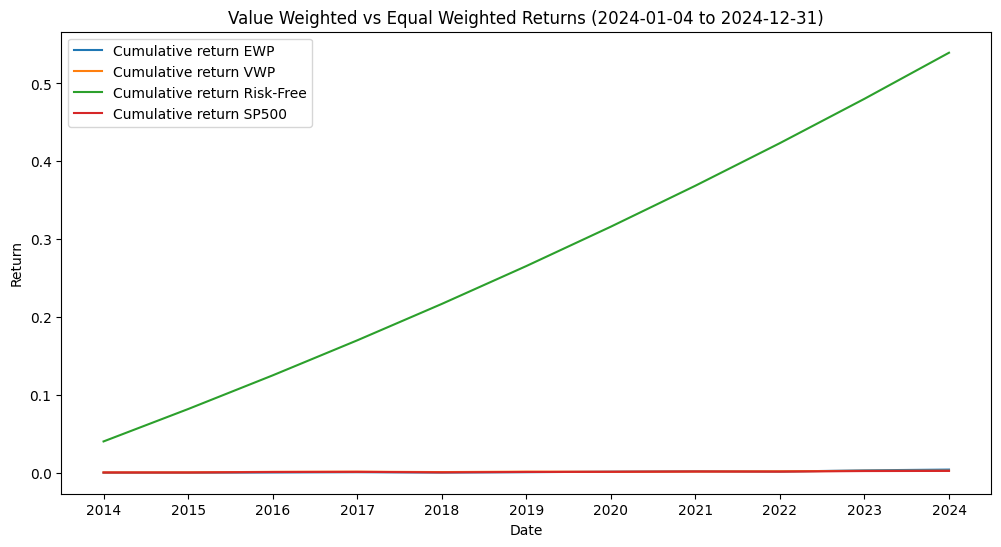

In [ ]:
cumulative_returns_EWP = (returns_per_year["Annually_Return_VWP"]+1).cumprod() - 1
cumulative_returns_VWP = (returns_per_year["Annually_Return_EWP"]+1).cumprod() - 1
cumulative_returns_RiskFree = (returns_per_year["Annually_Return_with_Risk_Free_Asset"]+1).cumprod() - 1
cumulative_returns_SP500 = (returns_per_year["Annually_Return_with_SP500"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(returns_per_year["Date"], cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(returns_per_year["Date"], cumulative_returns_VWP, label="Cumulative return VWP")
plt.plot(returns_per_year["Date"], cumulative_returns_RiskFree, label="Cumulative return Risk-Free")
plt.plot(returns_per_year["Date"], cumulative_returns_SP500, label="Cumulative return SP500")

plt.title(f"Value Weighted vs Equal Weighted Returns ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

## Plot cumulative returns for both porfolios, S&P 500 and risk-free using daily returns

In [ ]:
returns_per_day = portfolios.copy()

returns_per_day["Daily_Return_with_Risk_Free_Asset"] = risk_free_daily_rate
returns_per_day["Daily_Return_with_SP500"] = df_SP500["Daily_Return"]

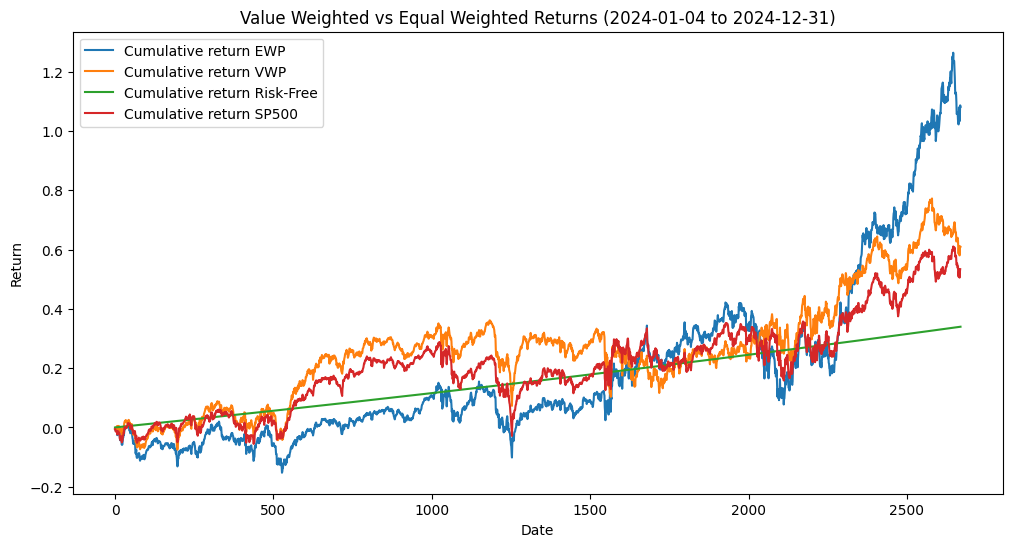

In [ ]:
cumulative_returns_EWP = (returns_per_day["Daily_Return_with_Value_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_VWP = (returns_per_day["Daily_Return_with_Equal_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_RiskFree = (returns_per_day["Daily_Return_with_Risk_Free_Asset"]+1).cumprod() - 1
cumulative_returns_SP500 = (returns_per_day["Daily_Return_with_SP500"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(returns_per_day.index, cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(returns_per_day.index, cumulative_returns_VWP, label="Cumulative return VWP")
plt.plot(returns_per_day.index, cumulative_returns_RiskFree, label="Cumulative return Risk-Free")
plt.plot(returns_per_day.index, cumulative_returns_SP500, label="Cumulative return SP500")

plt.title(f"Value Weighted vs Equal Weighted Returns ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()